## GEOF213: Week 10
### Geostrophic flow and the thermal wind equation
#### K. Daae, H. Ervik

In this exercise we will work with geostrophic currents (chapter 7) and the termal wind equation (chapter 15). 

We will first use observational data from the Faroe Bank Channel, obtained in 2012, and then from Skagerrak in 2017. The data from Skagerrak was kindly provided by Göran Björk, at the University of Gothenburg, Sweden.

#### Overview of exercises

Before class, complete exercises a-d. For exercises d-k, most python code is already written, and you will need to execute and add some plots. For each line of code, please make a comment what it does, **before class**. This will hlep you understand how to code in python, and help you to complete exercises m-o (Skagerrak).

#### Part a):
Start with the general form of the equations of motion, and show which assumption are made in the geostrophic approximation:

$$
-fv = \frac{1}{\rho} \frac{\partial p}{\partial x}, 
\qquad +fu=-\frac{1}{\rho} \frac{\partial p}{\partial y},
\qquad - \frac{\partial p}{\partial z}-\rho g=0
$$

#### Part b):
Assume hydrostatic and geostrophic balance and show that the vertical shear of an ocean current can be expressed as below.
These equations are called the _Thermal wind relation_, and are often used to obtain velocities from hydrographic sections. Note that the equations give the velocity shear, $(\partial v / \partial z)$, and not the absolute velocity

$$
\frac{\partial v}{\partial z} = - \frac{g}{f\rho_0} \frac{\partial\rho}{\partial x},
\qquad 
\frac{\partial u}{\partial z} = + \frac{g}{f\rho_0} \frac{\partial\rho}{\partial y}
$$

#### Part c):
Please download the files `FBC.nc` and `Skagex.nc` to complete the exercise. The files should be placed in the same folder as this exercise.

#### Import python packages required for this notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import gsw

import xarray as xr
import pandas as pd

## The Faroe Bank channel

A map of the Faroe Bank Channel (FBC) with CTD stations are shown in Figure 5. A NetCDF4 file containing data from the CTD transect is provided in the file FBC.nc. The data is organised in an xarray Dataset structure. For an introduction to xarray, check out their [documentation](http://xarray.pydata.org/en/stable/quick-overview.html). Have a look at the most important [terminology](http://xarray.pydata.org/en/stable/terminology.html) too. The dataset has two dimensions, `P` (pressure) and `station`. Each station also has a coordinate denoting the latitude, longitude, bottom depth, and date. For each station and for each pressure value, data on conservative temperature (`CT`), absolute salinity (`SA`), and potential density anomaly (`SIGTH`) is available.

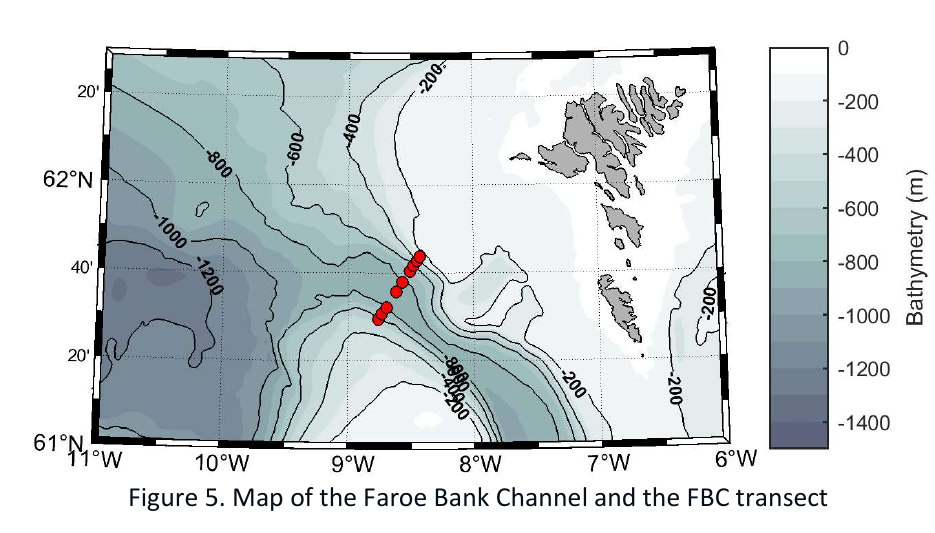


#### Part d):
Load the FBC data into Python by typing `fbc=xr.open_dataset("FBC.nc")`. Let's explore some basic functionality of the dataset. An overview of the dataset can be viewed by entering the dataset on the last line of a cell and running it. Alternatively, you can `print(fbc)`. In the notebook, you can click on the "dataset" symbol to the right of each entry to expand the data along that coordinate/variable. The data can also be printed by typing e.g. `fbc.station`.

In [2]:
# Open the dataset
fbc=xr.open_dataset("FBC.nc")
# Put the dataset on the last line of the cell to get an overview of its contents.
fbc

<xarray.Dataset>
Dimensions:       (P: 860, station: 9)
Coordinates:
  * P             (P) float64 0.0 1.01 2.019 3.029 ... 866.1 867.1 868.1 869.1
  * station       (station) int64 694 695 696 697 698 699 700 701 702
    lat           (station) float64 ...
    lon           (station) float64 ...
    bottom_depth  (station) int64 ...
    date          (station) datetime64[ns] ...
Data variables:
    SA            (P, station) float64 ...
    CT            (P, station) float64 ...
    SIGTH         (P, station) float64 ...

In [3]:
# See the values of a coordinate or variable:
fbc.station
# Equivalently, type: fbc['station']

<xarray.DataArray 'station' (station: 9)>
array([694, 695, 696, 697, 698, 699, 700, 701, 702])
Coordinates:
  * station       (station) int64 694 695 696 697 698 699 700 701 702
    lat           (station) float64 61.73 61.71 61.69 ... 61.54 61.51 61.49
    lon           (station) float64 -8.43 -8.45 -8.477 ... -8.695 -8.729 -8.758
    bottom_depth  (station) int64 329 456 601 701 704 860 804 666 591
    date          (station) datetime64[ns] 2012-06-09T20:06:34 ... 2012-06-10...

xarray data structures inherit from pandas `DataFrame`s. As such, if you're familiar with [pandas](https://pandas.pydata.org/docs/getting_started/index.html#getting-started), many of those methods carry directly over to working with xarray. For example, let's find the Westernmost station among the data and use it as our reference station for all calculations with the dataset.

In [4]:
# Find longitude and latitude of Westernmost station and use it as the reference station
ref_st = fbc.where(fbc.lon==fbc.lon.min(), drop=True)
ref_lon, ref_lat = ref_st.lon.values, ref_st.lat.values
ref_lon, ref_lat

(array([-8.75783333]), array([61.491]))

Next, let's use a method from the [gsw](https://teos-10.github.io/GSW-Python/) toolbox. To find out exactly how the method works, check out the gsw documentation pages. Click the link and search for `distance` in the search bar. It is good practice to search the documentation when using methods from external packages.

In [5]:
dists = np.empty(0)
for stid in fbc.station:
    # Find distance to reference station, in km.
    dist = gsw.distance(
        np.append(ref_lon, fbc.sel(station=stid).lon.values), 
        np.append(ref_lat, fbc.sel(station=stid).lat.values)
    ) / 1000
    dists = np.append(dists, dist)

# Add the distances as a coordinate along the `station` dimension.
fbc.coords['dist'] = ('station', dists)

#### Part e):
Plot transects of conservative temperature (`CT`), absolute salinity (`SA`), and potential density anomaly ($\sigma_0$, `SIGTH`) using the function provided below

In [6]:
def plot_section(x, y, z, title, xlabel='Distance (km)', ylabel='Depth (m)', show_fig=True, return_fig=False):
    """ Plot variable on section
    
    Parameters
    ----------
    x, y: array-like
        values along x- and y-axes.
    z : array-like
        A scalar 2-D array. The values will be color-mapped.
    title : str
        Title of plot.
        
    """
    fig = plt.figure(figsize=(8,6))
    plt.pcolormesh(x, y, z, shading='auto')
    plt.colorbar()
    plt.gca().set_title(title, fontsize=25)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.gca().invert_yaxis()
    
    if show_fig:
        plt.show()
    
    if return_fig:
        return fig

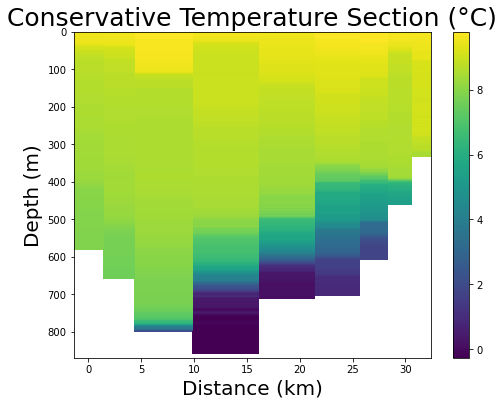

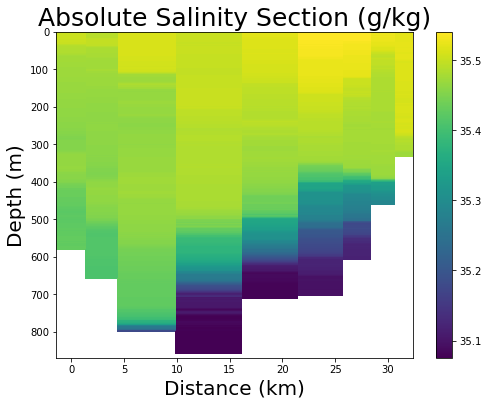

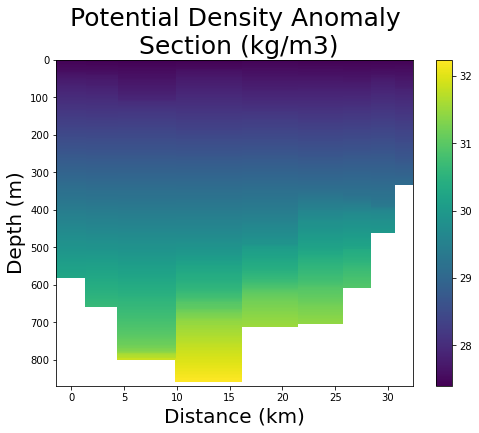

In [7]:
# Plot the CT section
plot_section(fbc.dist, fbc.P, fbc.CT, title='Conservative Temperature Section (°C)')

# Plot the SA section
plot_section(fbc.dist, fbc.P, fbc.SA, title='Absolute Salinity Section (g/kg)')

# Plot the potential density anomaly section
plot_section(fbc.dist, fbc.P, fbc.SIGTH, title='Potential Density Anomaly\n Section (kg/m3)')

#### Part f):
How do you think the velocity changes with depth? (Hint: Look at the horizontal density
gradient)


### <b> Answer: </b>

<div class="alert alert-block alert-warning">
Please write your answer here
</div>

### Part g):
Choose two stations with a large horizontal density gradient at depth. Plot vertical density profiles of the two stations, and estimate the horizontal density gradient ($\Delta\rho/\Delta x$) at a chosen depth (e.g. $z=500\ m$). The distance between the two stations can be calculated with `gsw.distance` as before.

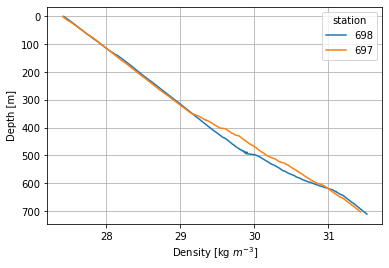

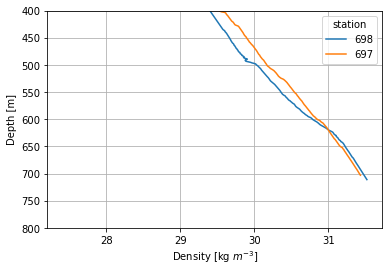

In [8]:
# Look close at two stations...
ind=[698,697]
st1,st2=ind

sub_fbc = fbc.sel(station=ind)

# Plot Density profiles
sub_fbc.SIGTH.plot.line(y='P')
plt.ylabel('Depth [m]')
plt.xlabel('Density [kg $m^{-3}$]')
plt.grid()
plt.gca().invert_yaxis()

# Take a closer look ...
plt.figure()
sub_fbc.SIGTH.plot.line(y='P')
plt.ylabel('Depth [m]')
plt.xlabel('Density [kg $m^{-3}$]')
plt.grid()
plt.ylim(400,800)  # Zoom in on a region
plt.gca().invert_yaxis()

Now we estimate the horizontal density gradient at 500 m depth.

In [9]:
zz=500

# Δρ is
fbc_rho = sub_fbc.sel(P=zz, method='nearest').SIGTH  # Find the density at the chosen depth
d_rho = (fbc_rho.sel(station=st1) - fbc_rho.sel(station=st2)).values

# Δx is:
dx = gsw.distance(
    sub_fbc.lon.values,
    sub_fbc.lat.values,
)[0]

# Δρ/Δx
print(f"The horizontal density gradient is {d_rho / dx:.4e}")

The horizontal density gradient is -2.3065e-05


#### Part h):
What is the vertical shear ($\Delta v/ \Delta z$) associated with the horizontal density gradient? Use the following constants: $g=9.81\ m\ s^{-2}$, $f=10^{-4}\ s^{-1}$, and $\rho_0=1027\ kg\ m^{-3}$

In [10]:
# Define constants
g=9.81
f=gsw.f(sub_fbc.sel(station=st1).lat.values)
rho=1027

# Compute dv/dz
dvdz=-g/(rho*f)*d_rho/dx
print(f"The vertical shear is {dvdz:.4e} s^{-1}")

The vertical shear is 1.7168e-03 s^-1


#### Part i): 
Assume that the horizontal density gradient is constant over a 100 m thick layer. What is the velocity difference between the upper and lower part of the layer? (Hint: Δz=100 m). 

Calculate and plot the geostrophic current between the two stations, using the functions available in the gsw toolbox. An example code is given below. The geostrophic current velocities are relative (baroclinic). This means that a barotropic background current must be added to obtain the true current velocities. If the barotropic currents are unknown, we may choose a vertical level where we believe the velocities are small. This is called the level of no motion (`p_ref` below). When we set `p_ref=0`, we obtain geostrophic currents relative to the surface (Below we set `p_ref=1` since our measurements start at `1 m`, and we want to avoid `NaNs`). It is common to set the level of no motion at the surface or at the bottom, depending on the structure of the hydrographic fields. Where do you think it is wise to set the `p_ref`? How would the geostrophic current look if you choose another `p_ref`?

### <b> Answer: </b>

<div class="alert alert-block alert-warning">
Please write your answer here
</div>

In [11]:
dz=100
print(f"The velocity difference over a {dz} m thick layer is {dz*dvdz:.3f} m/s")

The velocity difference over a 100 m thick layer is 0.172 m/s


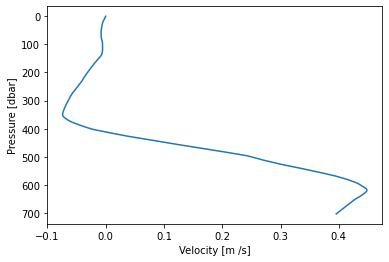

In [12]:
# Calculate dynamic height at each station
dynamic_height = [
    gsw.geo_strf_dyn_height(
        sub_fbc.sel(station=stind).SA.values, 
        sub_fbc.sel(station=stind).CT.values, 
        sub_fbc.sel(station=stind).P.values,
        p_ref=0
    )
    for stind in ind
]
dynamic_height = np.vstack(dynamic_height).T

sub_fbc = sub_fbc.assign(dynamic_height=(('P', 'station'), dynamic_height))

# Calculate geostrophic velocity with level of no motion relative to the surface
# https://teos-10.github.io/GSW-Python/geostrophy.html
vel,lon,lat=gsw.geostrophic_velocity(
    sub_fbc.dynamic_height.values,
    sub_fbc.lon.values,sub_fbc.lat.values,
    0,  # sea pressure
)

plt.figure()
plt.plot(vel,sub_fbc.P.values)
plt.gca().invert_yaxis()
plt.ylabel('Pressure [dbar]')
plt.xlabel('Velocity [m /s]')
plt.show() 

#### Part j):
What is the difference in geostrophic current across the 100 m thick layer zz-50 to zz+50 m? How well does this compare with your estimates from exercise g)?

In [13]:
print(vel[zz+50]-vel[zz-50])

[0.24936003]


### <b> Answer: </b>

<div class="alert alert-block alert-warning">
Please write your answer here
</div>

#### Part k):
Calculate and plot the geostrophic velocity across the entire section. How does it compare with the measured currents toward NW (perpendicular to the transect) shown in Figure 6.
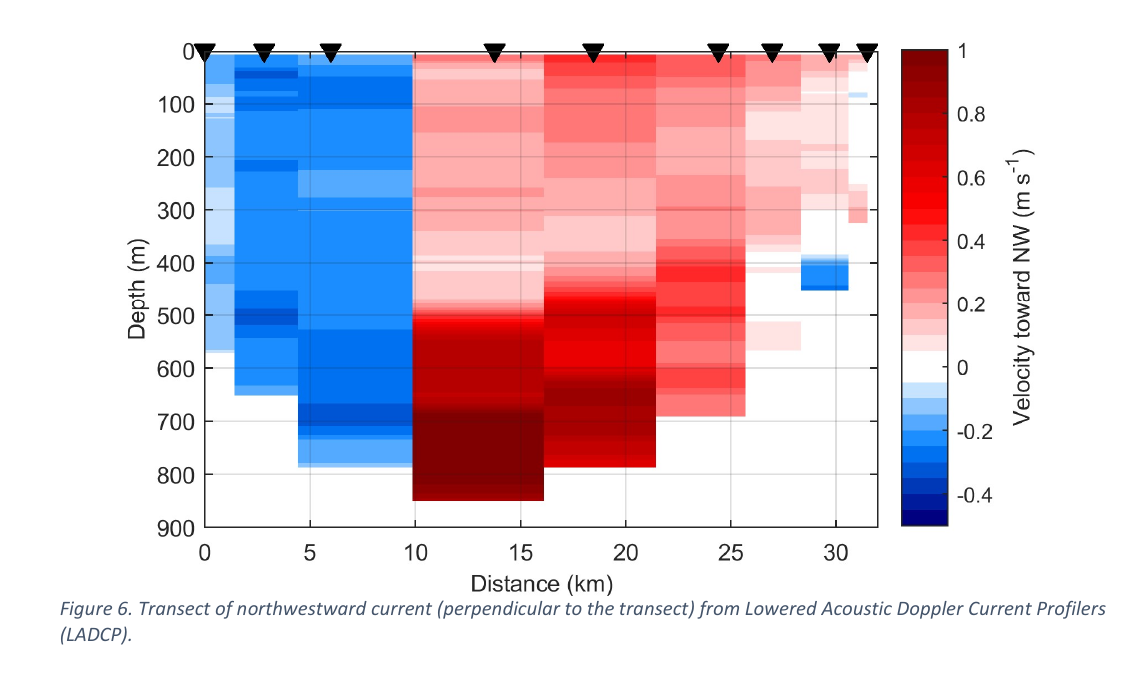



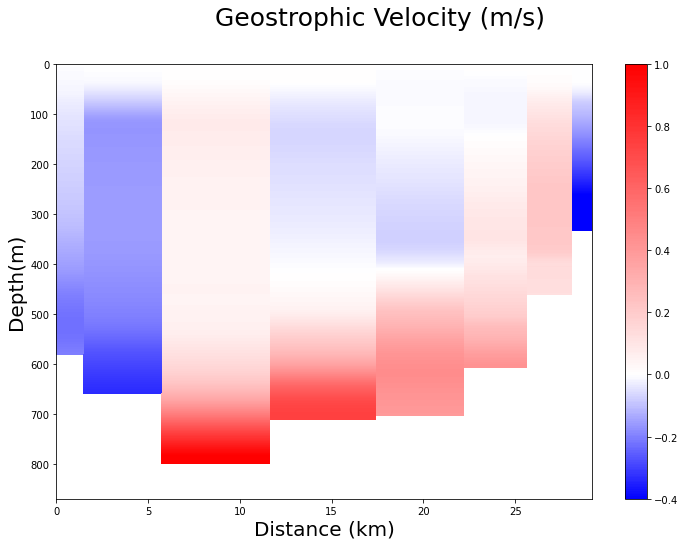

In [14]:
# Calculate dynamic height at each station
dynamic_height = [
    gsw.geo_strf_dyn_height(
        fbc.sel(station=station).SA.values,
        fbc.sel(station=station).CT.values,
        fbc.sel(station=station).P.values,
        p_ref=0,
    )
    for station in fbc.station
]
dynamic_height = np.vstack(dynamic_height).T

fbc = fbc.assign(dynamic_height=(('P', 'station'), dynamic_height))

# Calculate geostrophic velocity with level of no motion relative to the surface
# https://teos-10.github.io/GSW-Python/geostrophy.html
vel,lon,lat=gsw.geostrophic_velocity(
    fbc.dynamic_height.values,
    fbc.lon.values, fbc.lat.values,
    0,  # sea pressure
)

## Lon and lat now are in the middle of the cell, so you need to calculate a new distance section
# Find longitude and latitude of Westernmost station
west_ind = np.where(lon==lon.min())[0]
ref_lat, ref_lon = lat[west_ind], lon[west_ind]

dists = np.empty(0)
for lat_i, lon_i in zip(lat, lon):
    # Find distance to reference station, in km.
    dist = gsw.distance(
        np.append(ref_lon, lon_i), 
        np.append(ref_lat, lat_i)
    ) / 1000
    dists = np.append(dists, dist)

# plot Geostrophic Velocity
vmin = -0.4
vmax = 1
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

plt.figure(figsize=(12,8))
plt.set_cmap('bwr') # bluewhitered

## NOTE: Find out why we need negative value on velocity to get
#        correct sign.
plt.pcolor(dists, fbc.P.values, -vel, norm=norm, shading='auto')
plt.colorbar()
plt.xlim(0, dists.max())
plt.suptitle('Geostrophic Velocity (m/s)', fontsize=25)
plt.xlabel('Distance (km)', fontsize=20)
plt.ylabel('Depth(m)', fontsize=20)
plt.gca().invert_yaxis()
plt.show()

### <b> Answer: </b>

<div class="alert alert-block alert-warning">
Please write your answer here
</div>

#### Part l):
Could you think of any adjustments to the geostrophic currents that could reduce the
discrepancies? Is the ocean surface flat?

### <b> Answer: </b>

<div class="alert alert-block alert-warning">
Please write your answer here
</div>

## Skagerrak

Below is a map and a density transect from ure from Skagerrak, outside the west coast of Norway.

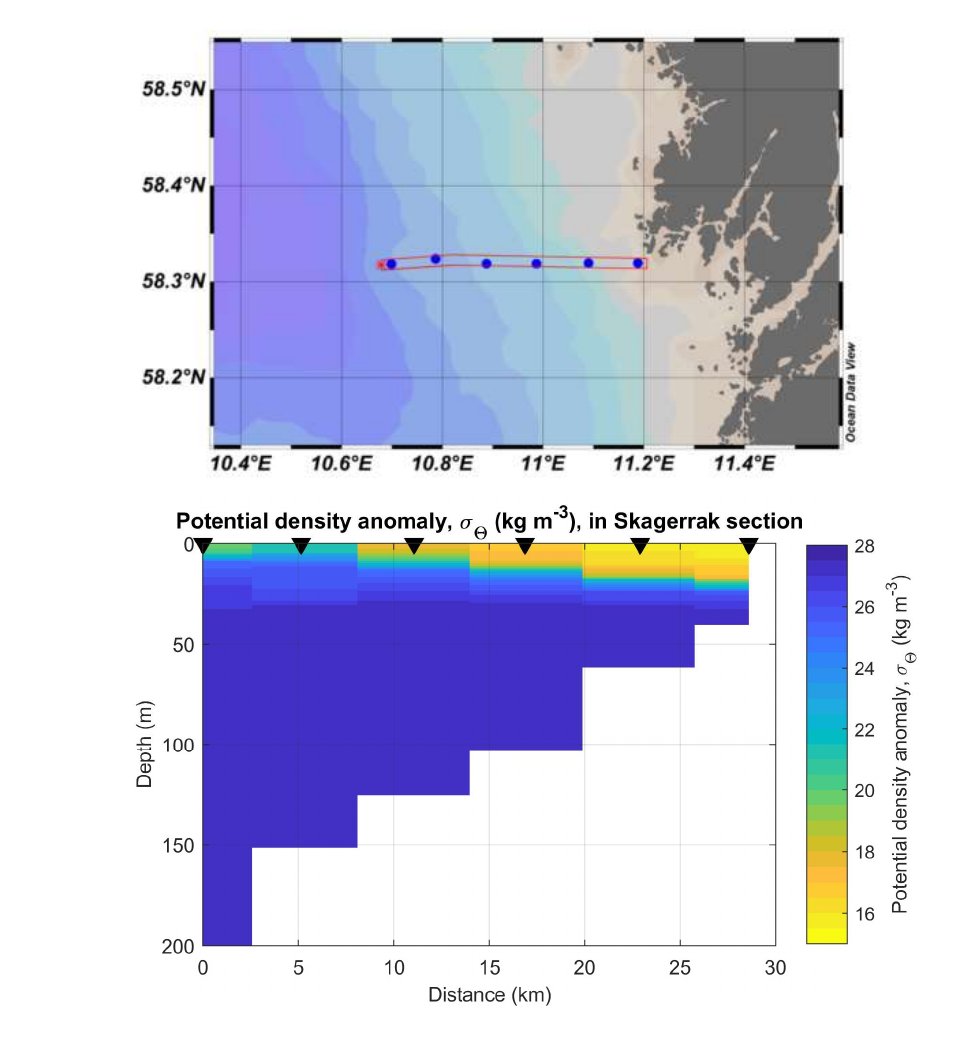


#### Part m):
Where do you think it makes sense to place the level of no motion in this Skagerrak section?

### <b> Answer: </b>

<div class="alert alert-block alert-warning">
Please write your answer here
</div>

#### Part n):
Load the data from Skagerrak into Python, and plot the density section. The data file is called `Skagex.nc`.


## NOTE: 
The code below can be considered a solution. For students, all code bits below could be removed.

In [15]:
skag = xr.open_dataset("Skagex.nc")
skag

<xarray.Dataset>
Dimensions:       (P: 200, station: 6)
Coordinates:
  * P             (P) float64 0.0 1.009 2.019 3.028 ... 197.9 198.9 200.0 201.0
  * station       (station) int64 1 2 3 4 5 6
    lat           (station) float64 ...
    lon           (station) float64 ...
    bottom_depth  (station) int64 ...
    date          (station) datetime64[ns] ...
Data variables:
    SA            (P, station) float64 ...
    CT            (P, station) float64 ...
    SIGTH         (P, station) float64 ...

In [16]:
# Find longitude and latitude of Westernmost station and use it as the reference station
ref_st = skag.where(skag.lon==skag.lon.min(), drop=True)
ref_lon, ref_lat = ref_st.lon.values, ref_st.lat.values

dists = np.empty(0)
for stid in skag.station:
    # Find distance to reference station, in km.
    dist = gsw.distance(
        np.append(ref_lon, skag.sel(station=stid).lon.values), 
        np.append(ref_lat, skag.sel(station=stid).lat.values)
    ) / 1000
    dists = np.append(dists, dist)

skag.coords['dist'] = ('station', dists)

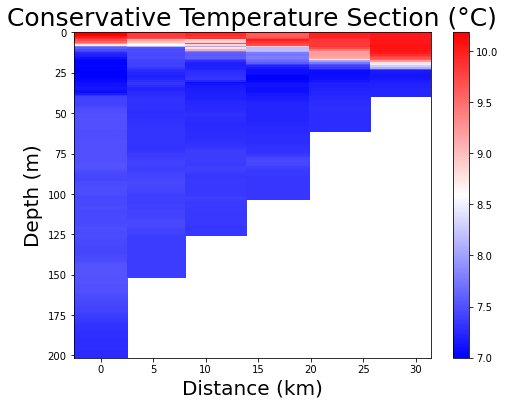

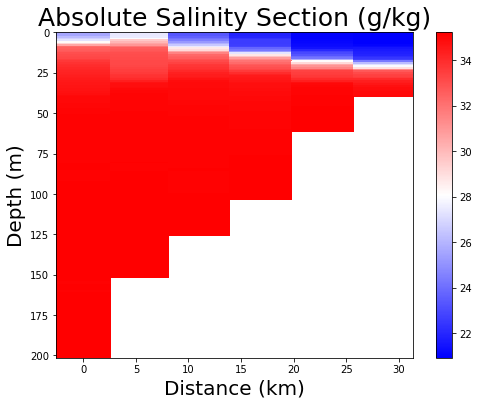

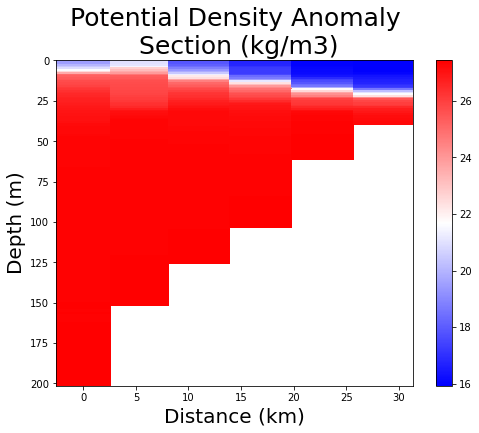

In [17]:
# Plot the CT section
plot_section(skag.dist, skag.P, skag.CT, title='Conservative Temperature Section (°C)')

# Plot the SA section
plot_section(skag.dist, skag.P, skag.SA, title='Absolute Salinity Section (g/kg)')

# Plot the potential density anomaly section
plot_section(skag.dist, skag.P, skag.SIGTH, title='Potential Density Anomaly\n Section (kg/m3)')

#### Part o):
Estimate geostrophic currents section in the same way as for the FBC data above. Consider how the current field looks for different levels of no motion.

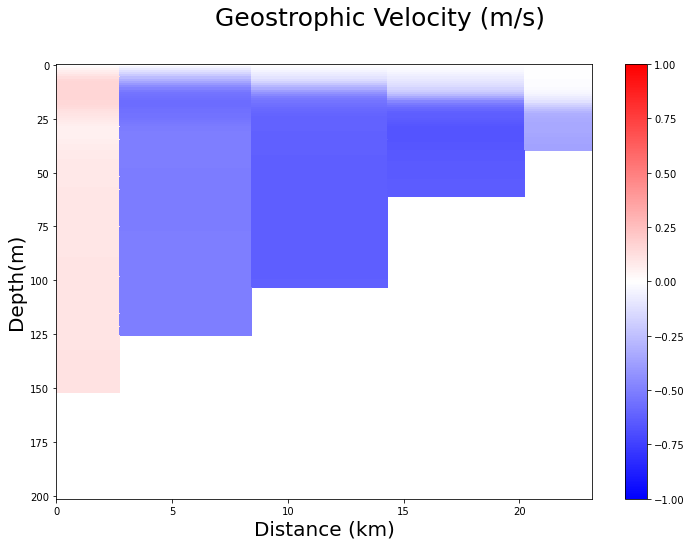

In [18]:
# Calculate dynamic height at each station
dynamic_height = [
    gsw.geo_strf_dyn_height(
        skag.sel(station=station).SA.values,
        skag.sel(station=station).CT.values,
        skag.sel(station=station).P.values,
        p_ref=0,
    )
    for station in skag.station
]
dynamic_height = np.vstack(dynamic_height).T

skag = skag.assign(dynamic_height=(('P', 'station'), dynamic_height))

# Calculate geostrophic velocity with level of no motion relative to the surface
# https://teos-10.github.io/GSW-Python/geostrophy.html
vel,lon,lat=gsw.geostrophic_velocity(
    skag.dynamic_height.values,
    skag.lon.values, skag.lat.values,
    0,  # sea pressure
)

## Lon and lat now are in the middle of the cell, so you need to calculate a new distance section
# Find longitude and latitude of Westernmost station
west_ind = np.where(lon==lon.min())[0]
ref_lat, ref_lon = lat[west_ind], lon[west_ind]

dists = np.empty(0)
for lat_i, lon_i in zip(lat, lon):
    # Find distance to reference station, in km.
    dist = gsw.distance(
        np.append(ref_lon, lon_i), 
        np.append(ref_lat, lat_i)
    ) / 1000
    dists = np.append(dists, dist)

# plot Geostrophic Velocity
vmin = -1
vmax = 1
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

plt.figure(figsize=(12,8))
plt.set_cmap('bwr') # bluewhitered

plt.pcolor(dists, skag.P.values, vel, norm=norm, shading='auto')
plt.colorbar()
plt.xlim(0, dists.max())
plt.suptitle('Geostrophic Velocity (m/s)', fontsize=25)
plt.xlabel('Distance (km)', fontsize=20)
plt.ylabel('Depth(m)', fontsize=20)
plt.gca().invert_yaxis()
plt.show()